In [15]:
import yaml
from typing import Sequence
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from typing import TypedDict
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import END, StateGraph, START, MessagesState
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from langchain_core.documents import Document
import numpy as np


In [4]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)
config

{'embedding': 'dunzhang/stella_en_1.5B_v5', 'llm': 'gemma2:27b'}

In [5]:
model_name = config["embedding"]
model_kwargs = {'device': 'cuda', "trust_remote_code": True}

embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
)

vector_store = Chroma(
    collection_name="its_faq",
    persist_directory="db",
    embedding_function=embedding_model,
    collection_metadata={"hnsw:space": "cosine"}
)

# vector_store_policies = Chroma(
#     collection_name="uh_policies",
#     persist_directory="db",
#     embedding_function=embedding_model,
#     collection_metadata={"hnsw:space": "cosine"}
# )

In [6]:
retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}
)

# policy_retriever = vector_store_policies.as_retriever(
#     search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}
# )

# lotr = EnsembleRetriever(retrievers=[retriever, policy_retriever], search_kwargs={"k": 2})

In [7]:
retriever.invoke("what is duo mobile?")

[Document(metadata={'source': 'https://www.hawaii.edu/askus/1859'}, page_content='##  Duo Mobile app 4.0 update\n### Overview\nThe Duo Mobile 4.0 version of the app is a significant update to the user\ninterface. This update will be released on the following schedule:\n  * For iOS: October 11 through 18, 2021\n  * For Android: October 11 through 15, 2021\nDuo Mobile 4.0 requires\n  * iOS 13 and up\n  * Android 8 and up\nOlder versions of the Duo Mobile app will continue to work.\n### Summary of changes\nThe following are some of the changes to the Duo Mobile app in version 4.0.\n**New Duo Approve screen**\nIn versions prior to 4.0, the _Approve_ button was on the left and the _Deny_\nbutton was on the right. In Duo Mobile 4.0, the _Approve_ button has been\nmoved to the **right** , and the _Deny_ button moved to the **left**. Duo made\nthis change to follow the industry standard of placing positive actions on the\nright (move forward in the flow of action), and negative actions on the 

In [8]:
llm = ChatOllama(model=config['llm'], temperature=0)

# models_to_try = ["google/gemma-2-2b-it", "google/gemma-2-9b-it", "microsoft/Phi-3-small-128k-instruct", "microsoft/Phi-3.5-mini-instruct"]

In [9]:
prompt_injection_ds = load_dataset("deepset/prompt-injections")

train = prompt_injection_ds["train"]
train_X, train_y = train["text"], train["label"]
train_X = embedding_model.embed_documents(train_X)
train_X = np.array(train_X)

test = prompt_injection_ds["test"]
test_X, test_y = test["text"], test["label"]
test_X = embedding_model.embed_documents(test_X)
test_X = np.array(test_X)

prompt_injection_classifier = LogisticRegression(random_state=0).fit(train_X, train_y)

In [11]:
class AgentState(MessagesState):
    retriever: str

class ChatHistoryCheckState(AgentState):
    can_answer_from_history: bool

class ReformulatedOutputState(AgentState):
    reformulated: str

class GetDocumentsOutputState(AgentState):
    relevant_docs: Sequence[Document]

class AgentInputState(AgentState, ChatHistoryCheckState, ReformulatedOutputState, GetDocumentsOutputState):
    pass

class AgentOutputState(TypedDict):
    message: BaseMessage
    sources: Sequence[str]

In [34]:
def call_model(state: AgentInputState) -> AgentOutputState:
    system_prompt = """You are Hoku, an AI assistant specialized in answering questions about UH Manoa."""

    qa_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", """Context: {context}\n\n
         {input}\n
         Provide complete answers based solely on the given context.
         If the information is not available in the context, respond with 'I don't know'.
         Ensure your responses are concise and informative.
         Do not mention the context in your response."""),
    ])

    relevant_docs = state['relevant_docs']
    context = "\n\n".join(d.page_content for d in relevant_docs)

    # if len(relevant_docs) == 0:
    #     return {"message": "I'm sorry, I do not know the answer to that question", "sources": []}

    chain = qa_prompt | llm
    response = chain.invoke({
        "chat_history": state["messages"],
        "context": context,
        "input": state['reformulated']
    })

    return {"message": response, "sources": [doc.metadata["source"] for doc in relevant_docs]}

def answer_from_history(state: ChatHistoryCheckState) -> AgentOutputState:
    system_prompt = """You are Hoku, an assistant for answering questions about UH Manoa.
    Answer the latest question using ONLY information from the chat history.
    If you cannot fully answer the question from the chat history, respond with "I don't know"."""

    history_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
    ])
    
    chain = history_prompt | llm
    response = chain.invoke({"chat_history": state["messages"]})
    return {"message": response, "sources": []}

def check_chat_history(state: AgentState) -> ChatHistoryCheckState:
    if len(state["messages"]) <= 1:
        return {"can_answer_from_history": False}
    
    system_prompt = """Given the chat history and the latest question, determine if the question can be fully answered using ONLY the information present in the chat history.
    Return 'yes' if it can be answered completely from chat history, 'no' if it requires additional information.
    Only analyze - do not answer the question."""

    check_history_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
    ])
    
    chain = check_history_prompt | llm
    result = chain.invoke({"chat_history": state["messages"]}).content.lower()
    return {"can_answer_from_history": "yes" in result}

def greeting_agent(state: AgentState):
    system_prompt = (
        "You are Hoku, an assistant for answering questions about UH Manoa.\n"
        "Provide accurate and concise answers based solely on the given context.\n"
        "If the information is not available in the context, respond with 'I'm sorry, I don't know the answer to that'.\n"
        "Answer politely and concisely.\n"
    )

    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder("query"),
        ]
    )

    chain = qa_prompt | llm
    response = chain.invoke({"query": state["messages"]})
    return {"message": response, "sources": []}

def reformulate_query(state: AgentState) -> ReformulatedOutputState:
    if len(state["messages"]) == 1:
        return {"reformulated": state["messages"][0].content}
    
    contextualize_q_system_prompt = (
        "Given the chat history and the latest user question, "
        "rephrase the question to be self-contained and clear without relying on the chat history. "
        "Ensure the reformulated question retains the original intent and context. "
        "Do NOT answer the question. "
        "Only return the reformulated question if needed, otherwise return it as is."
    )

    contextualize_q_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", contextualize_q_system_prompt),
            MessagesPlaceholder("chat_history"),
        ]
    )
    
    chain = contextualize_q_prompt | llm
    reformulated = chain.invoke({"chat_history": state["messages"]}).content
    return {"reformulated": reformulated}

def get_documents(state: ReformulatedOutputState) -> GetDocumentsOutputState:
    reformulated = state["reformulated"]

    if state["retriever"] == "askus":
        relevant_docs = retriever.invoke(reformulated)
    # elif state["retriever"] == "policies":
    #     relevant_docs = policy_retriever.invoke(reformulated)
    else:
        relevant_docs = []

    if len(relevant_docs) > 2:
        relevant_docs = relevant_docs[:2]
    
    return {"relevant_docs": relevant_docs}

def should_call_agent(state: GetDocumentsOutputState):
    return len(state["relevant_docs"]) > 0

def is_prompt_injection(state: AgentState):
    last_message = state["messages"][-1]
    embedding = embedding_model.embed_query(last_message.content)
    is_injection = prompt_injection_classifier.predict([embedding])[0]
    return "prompt_injection" if is_injection else "safe"

def handle_error(state) -> AgentOutputState:
    message = "Iʻm sorry, I cannot fulfill that request."
    return {"message": message, "sources": []}

def should_use_rag(state: ChatHistoryCheckState):
    return "rag" if not state["can_answer_from_history"] else "history"

In [35]:
# Compile Agent with new workflow
workflow = StateGraph(input=AgentState, output=AgentOutputState)

# Add nodes
workflow.add_node("handle_error", handle_error)
workflow.add_node("check_chat_history", check_chat_history)
workflow.add_node("answer_from_history", answer_from_history)
workflow.add_node("reformulate_query", reformulate_query)
workflow.add_node("get_documents", get_documents)
workflow.add_node("rag_agent", call_model)

# Add edges with new logic
workflow.add_conditional_edges(
    START,
    is_prompt_injection,
    {
        "prompt_injection": "handle_error",
        "safe": "check_chat_history"
    }
)

workflow.add_conditional_edges(
    "check_chat_history",
    should_use_rag,
    {
        "history": "answer_from_history",
        "rag": "reformulate_query"
    }
)

workflow.add_edge("reformulate_query", "get_documents")
workflow.add_edge("get_documents", "rag_agent")
workflow.add_edge("rag_agent", END)
workflow.add_edge("answer_from_history", END)
workflow.add_edge("handle_error", END)

agent = workflow.compile()

/tmp/ipykernel_34390/627563856.py:2: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  workflow = StateGraph(input=AgentState, output=AgentOutputState)


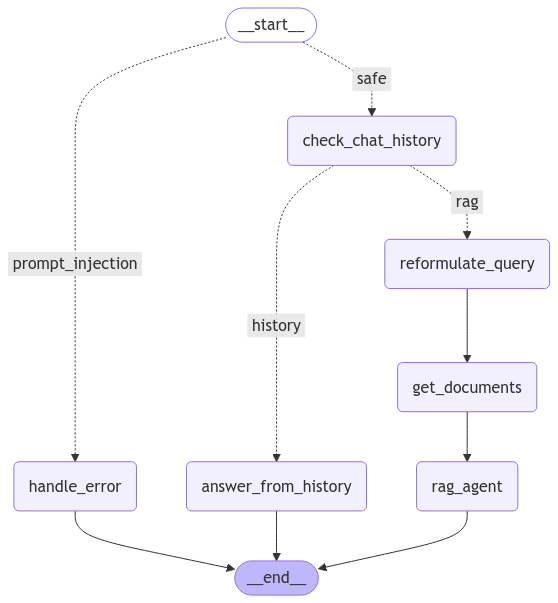

In [31]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [33]:
final_state = agent.invoke(
    {"messages": [HumanMessage(content="who is spongebob?")], "retriever": "askus"},
)

print(final_state)

No relevant docs were retrieved using the relevance score threshold 0.5


{'message': AIMessage(content='SpongeBob is a fictional character. \n', additional_kwargs={}, response_metadata={'model': 'gemma2:27b', 'created_at': '2024-11-12T21:01:35.291362926Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 368413724, 'load_duration': 31365792, 'prompt_eval_count': 102, 'prompt_eval_duration': 60000000, 'eval_count': 10, 'eval_duration': 274000000}, id='run-7b0fadd1-e69f-4f34-8311-0c382f2de430-0', usage_metadata={'input_tokens': 102, 'output_tokens': 10, 'total_tokens': 112}), 'sources': []}


In [37]:
inputs = {"messages": [HumanMessage(content="what is your name?")], "retriever": "askus"}
for chunk in agent.stream(inputs):
    print(chunk)

No relevant docs were retrieved using the relevance score threshold 0.5


{'check_chat_history': {'can_answer_from_history': False}}
{'reformulate_query': {'reformulated': 'what is your name?'}}
{'get_documents': {'relevant_docs': []}}
{'rag_agent': {'message': AIMessage(content='My name is Hoku. \n', additional_kwargs={}, response_metadata={'model': 'gemma2:27b', 'created_at': '2024-11-12T21:02:08.899263713Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 339980573, 'load_duration': 31180134, 'prompt_eval_count': 96, 'prompt_eval_duration': 60000000, 'eval_count': 9, 'eval_duration': 246000000}, id='run-0daebc95-5f72-4657-adb1-de4a52704ee4-0', usage_metadata={'input_tokens': 96, 'output_tokens': 9, 'total_tokens': 105}), 'sources': []}}


In [ ]:
from fastapi import FastAPI
from langserve import add_routes
import asyncio

app = FastAPI(
    title="AI Agent AskUs",
    version="1.1",
    description="A simple api server using Langchain's Runnable interfaces",
)

add_routes(
    app,
    agent,
    path="/askus",
)

import uvicorn

if __name__ == "__main__":
    config = uvicorn.Config(app)
    server = uvicorn.Server(config)
    loop = asyncio.get_running_loop()
    loop.create_task(server.serve())

    # uvicorn.run(app, host="localhost", port=8000)

INFO:     Started server process [509873]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)



     __          ___      .__   __.   _______      _______. _______ .______     ____    ____  _______
    |  |        /   \     |  \ |  |  /  _____|    /       ||   ____||   _  \    \   \  /   / |   ____|
    |  |       /  ^  \    |   \|  | |  |  __     |   (----`|  |__   |  |_)  |    \   \/   /  |  |__
    |  |      /  /_\  \   |  . `  | |  | |_ |     \   \    |   __|  |      /      \      /   |   __|
    |  `----./  _____  \  |  |\   | |  |__| | .----)   |   |  |____ |  |\  \----.  \    /    |  |____
    |_______/__/     \__\ |__| \__|  \______| |_______/    |_______|| _| `._____|   \__/     |_______|
    
LANGSERVE: Playground for chain "/askus/" is live at:
LANGSERVE:  │
LANGSERVE:  └──> /askus/playground/
LANGSERVE:
LANGSERVE: See all available routes at /docs/
INFO:     127.0.0.1:33158 - "POST /askus/invoke HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/uvicorn/protocols/http/httptools_impl.py", line 401, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/starlette/applications.py", line 123, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/home/exouser/miniconda3/envs/ai-agent-askus/li

INFO:     127.0.0.1:56528 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:56528 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:56528 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:60946 - "GET /askus/playground HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:60946 - "GET /askus/playground/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:60946 - "GET /askus/playground/assets/index-400979f0.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:60958 - "GET /askus/playground/assets/index-52e8ab2f.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:60958 - "GET /askus/playground/favicon.ico HTTP/1.1" 200 OK
INFO:     127.0.0.1:54332 - "POST /askus/stream_log HTTP/1.1" 200 OK


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/sse_starlette/sse.py", line 289, in __call__
    await wrap(partial(self.listen_for_disconnect, receive))
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/sse_starlette/sse.py", line 278, in wrap
    await func()
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/sse_starlette/sse.py", line 228, in listen_for_disconnect
    message = await receive()
              ^^^^^^^^^^^^^^^
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/site-packages/uvicorn/protocols/http/httptools_impl.py", line 555, in receive
    await self.message_event.wait()
  File "/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.12/asyncio/locks.py", line 212, in wait
    await fut
asyncio.exceptions.CancelledError: Cancelled by cancel scope 71e8487ac6e0

During handling of th